# 1. SETUP

## 1.1 Imports


In [90]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_discrete import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 PARAMETERS SETUP


In [91]:
# utils functions 
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed

def getTrajectory():
    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", max_episode_steps=500)
    states = []
    # get an initial state
    state, info = env.reset()
    states.append(state)
    done = False
    # play one episode
    done = False
    for i in range(6):
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(0) # only pushes left (0 is left, 1 is right)
        states.append(state)
    while not done:
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(1) # only pushes left (0 is left, 1 is right)
        states.append(state)
        done = terminated or truncated
        
    env.close()
    return states

# HYPERPARAMETERS
# environment hyperparams
n_steps = 250000
n_envs = 1
n_steps_per_update = 1
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 50000//(n_steps_per_update*n_envs) # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 
n_evaluations = n_updates // evaluation_interval

# Aggregate parameters
n_seeds = 3 # number of random seeds for the aggregation of plots
agents_seeds = [10, 42, 81] # Arbitrary seeds for the agents

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = False
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
env = gym.make("CartPole-v1")
env_eval = gym.make("CartPole-v1")
obs_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")


# AGENT
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

In [53]:


# Create a 2D NumPy array
arr = [[] for _ in range(3)]
print(arr)
#print(arr)
k =0
for i in range(3):
    arr[i].append(k)
    arr[i].append(k+1)
    arr[i].append(k+2)
    k+=3
# Value to append
print(arr)
print(arr[1])
# Append the value to the array


[[], [], []]
[[0, 1, 2], [3, 4, 5], [6, 7, 8]]
[3, 4, 5]


# 2. AGENT TRAINING

In [92]:
# LOGGED VARIABLES
critic_losses = np.zeros((n_updates+1, n_seeds))
actor_losses = np.zeros((n_updates+1, n_seeds))
entropies = np.zeros((n_updates+1, n_seeds))
episode_returns = [[] for _ in range(n_seeds)] # logs the returns of the agent in each episode
steps_episodes = [[] for _ in range(n_seeds)] # logs the steps taken of the agent in each episode
evaluation_returns = [[] for _ in range(n_seeds)] # logs the returns of the agent during evaluation
values = [[] for _ in range(n_seeds)] # logs the values of the agent on the fixed trajectory

# Running for the n_seeds agents 
for s, agent_seed in enumerate(agents_seeds):
    print(f"Running seed {agent_seed} for agent {s}")
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)
    # COUNTERS
    steps = 0
    ep_counter = 0
    ep_reward = 0

    # VARIABLE INITIALIZATION
    is_truncated = False
    is_terminated = False
    states, info = env.reset(seed=agent_seed) #only use the seed when resetting the first time
    fixed_trajectory = getTrajectory()
    #values = np.array(n_evaluations,len(fixed_trajectory)) # log the values over a trajectory

    # use tqdm to get a progress bar for training
    for steps in tqdm(range(n_updates+1)):
            

        # reset lists that collect experiences of a n_steps_per_update
        n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        # don't take mask and reward gradient
        masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
        n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
        end_states = []
        end_states_idx = [0]

        # play n_steps_per_update to collect data
        for step in range(n_steps_per_update):
            # select an action A_{t} using S_{t} as input for the agent, get actions and values Vt
            actions, action_log_probs, V_t, entropy = agent.select_action(states, bool_greedy=False)

            # ensure no grad is taken in the step
            with torch.no_grad():
                # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
                states, reward, is_terminated, is_truncated, infos = env.step(
                    actions.cpu().numpy()
                )
            if stochasticity_bool:
                # introduce stochasticity in the reward
                if np.random.rand() < stochastic_reward_probability:
                    reward = 0

            ep_reward += reward # increase episode return
            mask = not is_terminated # define mask for bootstrapping

            # log the value, reward and action log prob of the last step
            n_value_preds[step] = torch.squeeze(V_t)
            n_rewards[step] = torch.tensor(reward, device=device)
            n_action_log_probs[step] = action_log_probs

            # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
            masks[step] = torch.tensor(mask) # allows for correct bootstrapping
            
            # reset environment if truncated or terminated
            if is_terminated or is_truncated:
                states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor
                end_states.append(states_tensor)
                end_states_idx.append(step)
                states, info = env.reset() # do not use the seed when resetting again
                ep_counter += 1
                steps_episodes[s].append(steps)
                episode_returns[s].append(ep_reward)
                ep_reward = 0

        
        # if statement to make sure we don't append the end state twice
        if not is_terminated and not is_truncated:
            states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor
            end_states.append(states_tensor)
            end_states_idx.append(step)
        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            n_rewards,
            n_action_log_probs,
            n_value_preds,
            entropy,
            masks,
            gamma,
            end_states,
            end_states_idx
        )

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)

        # log the losses and entropy
        critic_losses[steps, s] = critic_loss.detach().cpu().numpy()
        actor_losses[steps, s] = actor_loss.detach().cpu().numpy()
        entropies[steps, s] = entropy.detach().mean().cpu().numpy()

        #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
        #on a newly initialized environment and plotting the evaluation statistics below.
        with torch.no_grad(): # No need to store gradients in the evaluation
            if steps % evaluation_interval == 0:
                print("EVALUATION")
                # evaluate
                returns = []
                episode_lengths = []
                for i in range(n_eval_runs):
                    # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                    if i == 0:
                        state, info = env_eval.reset(seed = agent_seed)
                        value = []
                        for state_traj in fixed_trajectory:
                            _, _, V_t, _ = agent.select_action(state_traj, bool_greedy=False)
                            value.append(V_t)
                        values[s].append(value)
                    else:
                        state, info = env_eval.reset()
                    episode_return = 0
                    episode_length = 0
                    while True:
                        action, _, _, _ = agent.select_action(state,bool_greedy=True)
                        state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                        episode_return += reward
                        episode_length += 1
                        if terminated or truncated:
                            break
                    returns.append(episode_return)
                    episode_lengths.append(episode_length)  
                print(returns)
                evaluation_returns[s].append(np.mean(returns))





Running seed 10 for agent 0


  0%|          | 0/250001 [00:00<?, ?it/s]

/Users/alexis/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 40/250001 [00:00<10:28, 397.43it/s]

EVALUATION
[56.0, 60.0, 63.0, 90.0, 37.0, 40.0, 39.0, 33.0, 34.0, 43.0]


 20%|█▉        | 49906/250001 [00:36<02:32, 1308.16it/s]

EVALUATION


 20%|██        | 50174/250001 [00:37<04:45, 700.72it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 40%|███▉      | 99937/250001 [01:13<01:47, 1390.41it/s]

EVALUATION


 40%|████      | 100213/250001 [01:13<03:27, 720.40it/s]

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 60%|█████▉    | 149861/250001 [01:49<01:11, 1390.91it/s]

EVALUATION


 60%|██████    | 150139/250001 [01:50<02:18, 722.92it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 442.0, 500.0, 500.0, 500.0, 500.0]


 80%|███████▉  | 199917/250001 [02:26<00:41, 1221.20it/s]

EVALUATION


 80%|████████  | 200179/250001 [02:27<01:12, 688.23it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


100%|█████████▉| 249885/250001 [03:03<00:00, 1390.90it/s]

EVALUATION


100%|██████████| 250001/250001 [03:03<00:00, 1359.51it/s]


[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Running seed 42 for agent 1


  0%|          | 115/250001 [00:00<03:38, 1144.46it/s]

EVALUATION
[10.0, 10.0, 9.0, 9.0, 10.0, 11.0, 9.0, 10.0, 9.0, 9.0]


 20%|█▉        | 49898/250001 [00:36<02:27, 1356.51it/s]

EVALUATION


 20%|██        | 50137/250001 [00:37<05:16, 631.47it/s] 

[500.0, 500.0, 500.0, 446.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 40%|███▉      | 99937/250001 [01:13<01:48, 1389.13it/s]

EVALUATION


 40%|████      | 100208/250001 [01:14<03:31, 709.70it/s]

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 60%|█████▉    | 149883/250001 [01:50<01:12, 1387.61it/s]

EVALUATION


 60%|██████    | 150152/250001 [01:50<02:23, 693.50it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 80%|███████▉  | 199976/250001 [02:27<00:36, 1371.40it/s]

EVALUATION


 80%|████████  | 200244/250001 [02:28<01:10, 701.77it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


100%|█████████▉| 249931/250001 [03:04<00:00, 1379.54it/s]

EVALUATION


100%|██████████| 250001/250001 [03:05<00:00, 1348.76it/s]


[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Running seed 81 for agent 2


  0%|          | 114/250001 [00:00<03:40, 1132.62it/s]

EVALUATION
[11.0, 9.0, 11.0, 9.0, 9.0, 9.0, 11.0, 10.0, 9.0, 8.0]


 20%|█▉        | 49931/250001 [00:36<02:25, 1378.60it/s]

EVALUATION


 20%|██        | 50203/250001 [00:37<03:37, 917.93it/s] 

[210.0, 261.0, 213.0, 312.0, 235.0, 268.0, 204.0, 210.0, 274.0, 295.0]


 40%|███▉      | 99975/250001 [01:13<01:48, 1385.54it/s]

EVALUATION


 40%|████      | 100243/250001 [01:13<03:34, 699.08it/s]

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 60%|█████▉    | 149978/250001 [01:50<01:12, 1378.95it/s]

EVALUATION


 60%|██████    | 150250/250001 [01:50<02:15, 736.99it/s] 

[434.0, 500.0, 457.0, 500.0, 457.0, 500.0, 301.0, 438.0, 459.0, 500.0]


 80%|███████▉  | 199862/250001 [02:26<00:35, 1398.09it/s]

EVALUATION


 80%|████████  | 200135/250001 [02:27<01:10, 709.98it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


100%|█████████▉| 249889/250001 [03:03<00:00, 1395.08it/s]

EVALUATION


100%|██████████| 250001/250001 [03:03<00:00, 1361.99it/s]

[333.0, 364.0, 350.0, 500.0, 289.0, 387.0, 272.0, 274.0, 300.0, 500.0]


# 3. RESULTS

## 3.1 PLOTTING

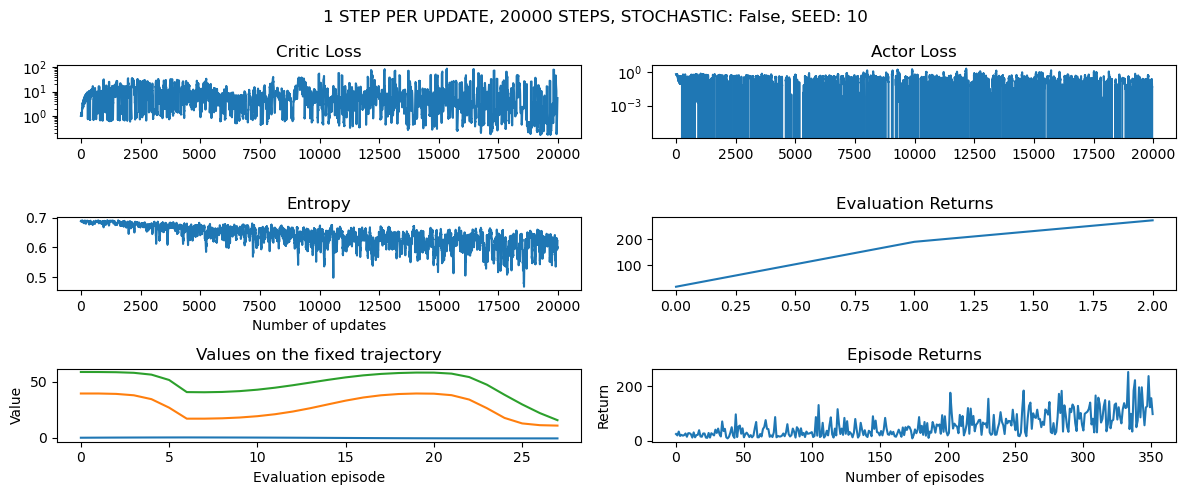

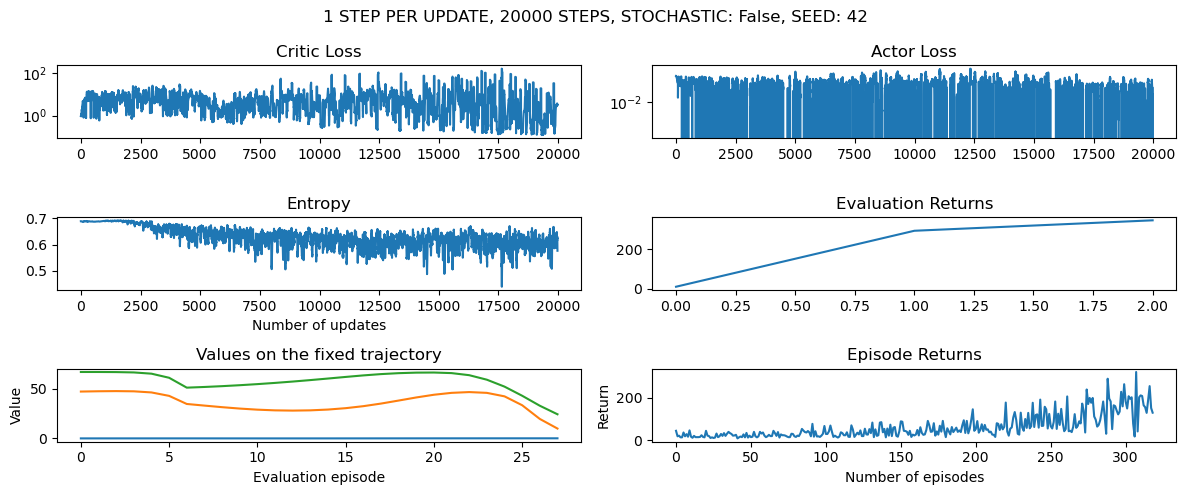

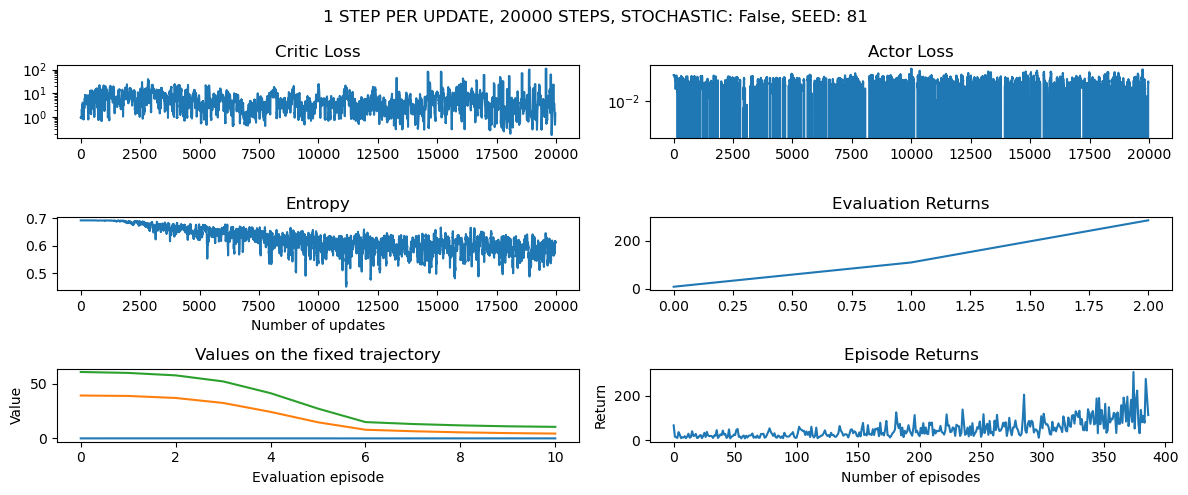

In [80]:
rolling_length = 30
for s, agent_seed in enumerate(agents_seeds):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 5))
    #set title of the plot
    fig.suptitle(f"{n_steps_per_update} STEP PER UPDATE, {n_steps} STEPS, STOCHASTIC: {stochasticity_bool}, SEED: {agent_seed}")

    #capped_loss = crit_loss[crit_loss < 1]
    critic_ma = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[0, 0].plot(critic_ma)
    axs[0, 0].set_title('Critic Loss')
    axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
 
    actor_ma = (
        np.convolve(actor_losses[:,s], np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[0, 1].plot(actor_ma)
    axs[0, 1].set_title('Actor Loss')
    axs[0, 1].set_yscale('log')  # Set log scale for the y-axis


    # entropy
    axs[1][0].set_title("Entropy")
   
    entropy_moving_average = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[1][0].plot(entropy_moving_average)
    axs[1][0].set_xlabel("Number of updates")



    #axs[1, 1].plot(steps_episodes, episode_returns)
    #axs[1, 1].set_title('Episode Rewards')
    axs[1, 1].plot(evaluation_returns[s])
    axs[1, 1].set_title('Evaluation Returns')

    # plot the values of the agent on the fixed trajectory
    val_array = np.array(values[s])
    val_array = np.squeeze(val_array)

    for i in range(val_array.shape[0]):
        axs[2, 0].plot(val_array[i])
    axs[2, 0].set_title('Values on the fixed trajectory')
    axs[2, 0].set_xlabel('Evaluation episode')
    axs[2, 0].set_ylabel('Value')

    # plot the episode returns
    axs[2, 1].plot(episode_returns[s])
    axs[2, 1].set_title('Episode Returns')
    axs[2, 1].set_xlabel('Number of episodes')
    axs[2, 1].set_ylabel('Return')

    plt.tight_layout()
    plt.show()


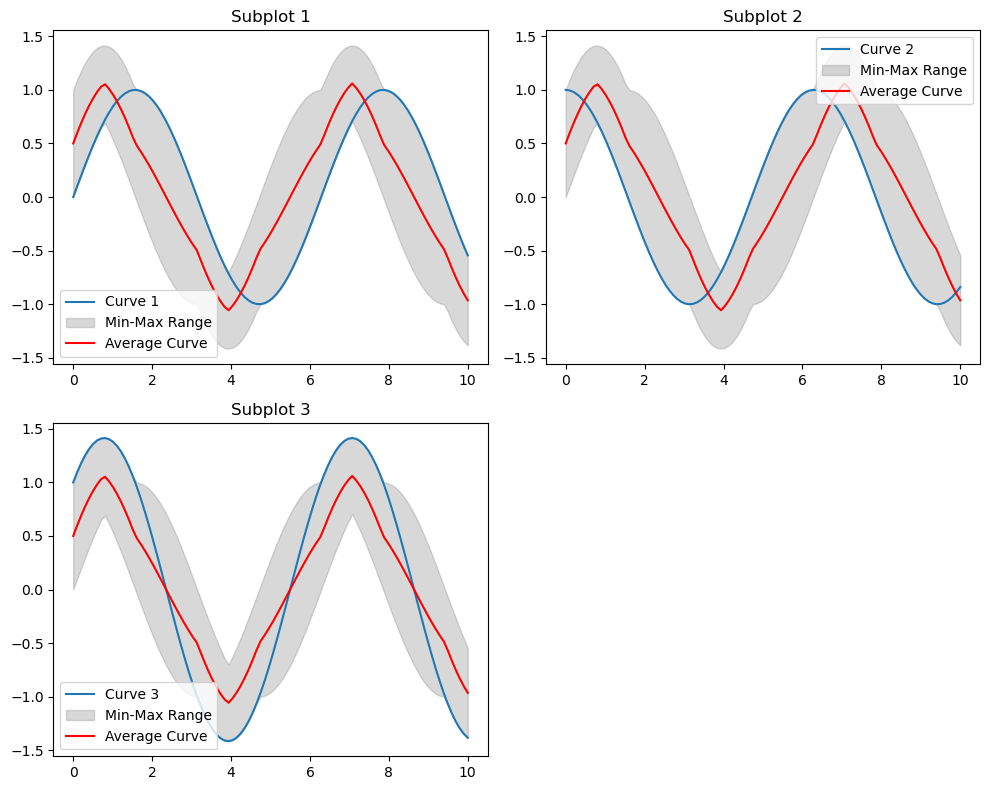

[0.6898995  0.68978077 0.68980727 ... 0.46335458 0.46216911 0.4618592 ]


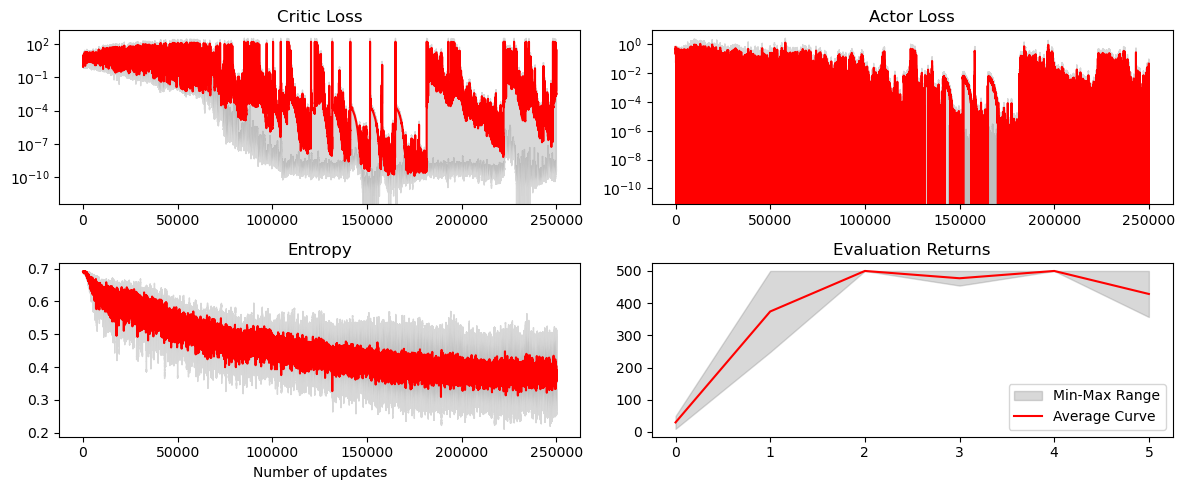

In [93]:
def aggregate_plot(y1,y2,y3):
    # Compute minimum and maximum curves
    y_min = np.minimum(np.minimum(y1, y2), y3)
    y_max = np.maximum(np.maximum(y1, y2), y3)

    # Compute average curve
    y_avg = (y_min + y_max) / 2

    return y_min, y_max, y_avg

rolling_length = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
#fig.suptitle(f"{n_steps_per_update} STEP PER UPDATE, {n_steps} STEPS, STOCHASTIC: {stochasticity_bool}, SEED: {agent_seed}")
critic_y =[[] for _ in range(n_seeds)]
actor_y =[[] for _ in range(n_seeds)]
entropy_y =[[] for _ in range(n_seeds)]

for s, agent_seed in enumerate(agents_seeds):
    critic_y[s] = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    actor_y[s] = (
        np.convolve(np.array(actor_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    entropy_y[s] = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    
critic_y_min, critic_y_max, critic_y_avg = aggregate_plot(critic_y[0],critic_y[1],critic_y[2])
actor_y_min, actor_y_max, actor_y_avg = aggregate_plot(actor_y[0],actor_y[1],actor_y[2])
entropy_y_min, entropy_y_max, entropy_y_avg = aggregate_plot(entropy_y[0],entropy_y[1],entropy_y[2])
reward_y_min, reward_y_max, reward_y_avg = aggregate_plot(evaluation_returns[0], evaluation_returns[1], evaluation_returns[2])
critic_x = np.arange(0, critic_y_min.shape[0])
actor_x = np.arange(0, actor_y_min.shape[0]) # Not necessary
entropy_x = np.arange(0, entropy_y_min.shape[0]) # Not necessary
reward_x = np.arange(0, reward_y_min.shape[0])

# Critic loss
axs[0, 0].fill_between(critic_x,critic_y_min, critic_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 0].plot(critic_x, critic_y_avg, color='red', label='Average Curve')
axs[0, 0].set_title('Critic Loss')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis

# Actor loss
axs[0, 1].fill_between(actor_x,actor_y_min, actor_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 1].plot(actor_x, actor_y_avg, color='red', label='Average Curve')
axs[0, 1].set_title('Actor Loss')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis

# Entropy
axs[1, 0].fill_between(entropy_x,entropy_y_min, entropy_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 0].plot(entropy_x, entropy_y_avg, color='red', label='Average Curve')
axs[1, 0].set_title("Entropy")
axs[1, 0].set_xlabel("Number of updates")

# Episode rewards
axs[1, 1].fill_between(reward_x,reward_y_min, reward_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 1].plot(reward_x, reward_y_avg, color='red', label='Average Curve')
axs[1, 1].set_title('Evaluation Returns')


""" TODO Add value plots"""


# Adjust layout
plt.tight_layout()
plt.legend()
# Show plot
plt.show()


# import matplotlib.pyplot as plt
# import numpy as np

# # Generate sample data for three curves
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.sin(x) + np.cos(x)

# # Plot each individual curve
# plt.plot(x, y1, label='Curve 1')
# plt.plot(x, y2, label='Curve 2')
# plt.plot(x, y3, label='Curve 3')

# # Compute minimum and maximum curves
# y_min = np.minimum(np.minimum(y1, y2), y3)
# y_max = np.maximum(np.maximum(y1, y2), y3)

# # Compute average curve
# y_avg = (y_min + y_max) / 2

# # Plot shaded area between minimum and maximum curves
# plt.fill_between(x, y_min, y_max, color='gray', alpha=0.3, label='Min-Max Range')

# # Plot average curve
# plt.plot(x, y_avg, color='red', label='Average Curve')

# # Add legend
# plt.legend()

# # Show plot
# plt.show()

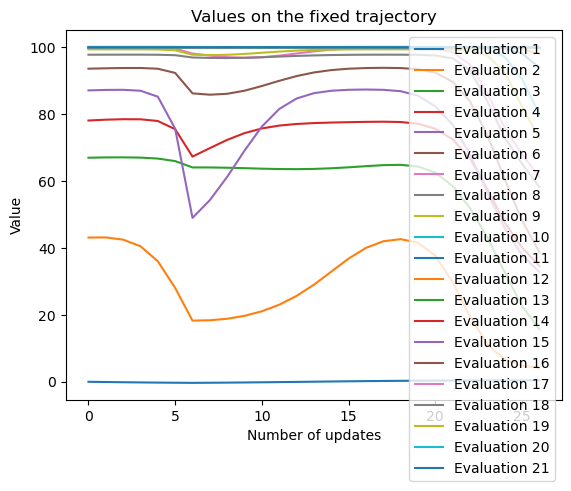

In [29]:
# plot the values of the agent on the fixed trajectory
values = np.array(values)
values = np.squeeze(values)

for i in range(values.shape[0]):
    plt.plot(values[i], label=f"Evaluation {i+1}")

plt.title('Values on the fixed trajectory')
plt.xlabel('Number of updates')
plt.ylabel('Value')
plt.legend()
plt.show()


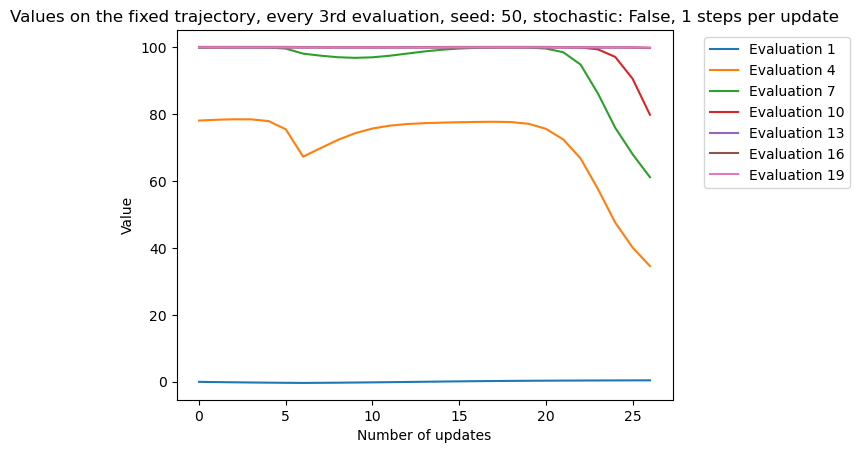

<Figure size 640x480 with 0 Axes>

In [38]:
values = np.array(values)
values = np.squeeze(values)

for i in range(0, values.shape[0], 3):
    plt.plot(values[i], label=f"Evaluation {i+1}")

plt.title(f'Values on the fixed trajectory, every 3rd evaluation, seed: {seed_value}, stochastic: {stochasticity_bool}, {n_steps_per_update} steps per update')
plt.xlabel('Number of updates')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
plt.savefig(f'figures/{n_steps_per_update}setps_step_stoch_seed{seed_value}.png', bbox_inches='tight')



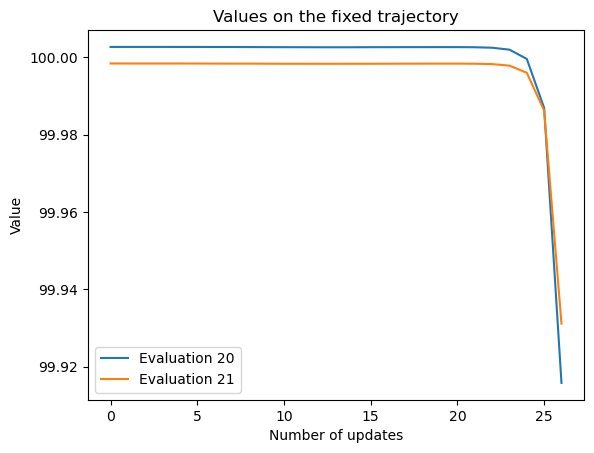

In [32]:
values = np.array(values)
values = np.squeeze(values)

for i in range(values.shape[0]-2, values.shape[0],1):
    plt.plot(values[i], label=f"Evaluation {i+1}")

plt.title('Values on the fixed trajectory')
plt.xlabel('Number of updates')
plt.ylabel('Value')
plt.legend()
plt.show()

In [12]:
values = np.array(values)
values.shape

(11, 9)

In [ ]:
plt.plot(steps_episodes,episode_returns)
plt.title("episode returns")
plt.xlabel("Number of evaluations")
plt.ylabel("Return")
plt.show()

## 3.2 SAVE PLOTS

In [33]:
#save the plot
if stochasticity_bool:
    fig.savefig(f"figures/A2C_{n_steps_per_update}step_stoch_seed{seed_value}_full.png")
else:
    fig.savefig(f"figures/A2C_{n_steps_per_update}step_nostoch_seed{seed_value}_full.png")

## 3.3 SAVE/LOAD AGENT WEIGHTS

In [6]:
save_weights = True
load_weights = False

actor_weights_path = "weights/actor_weights_stoch.h5"
critic_weights_path = "weights/critic_weights_stoch.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, 1)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

## 3.4 SHOWCASE AGENT

In [10]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :], bool_greedy=True)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...


/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


starting episode 1...
starting episode 2...


: 